# <Center> Homework 5: Classification </center>

This assignment needs the following two data files:
- train.csv: dataset for training
- test.csv: dataset for testing. 
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  I must admit that I'm addicted to "Version 2.0...|
|0|  I think it's such a shame that an enormous tal...|
|1|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|


## Q1 Classification

- Define a function `create_model(train_docs, train_y, test_docs, test_y, tokenizer=None, model_type='svm', stop_words='english', min_df = 1, print_result = True, algorithm_para=1.0`), where

    - `train_docs`: is a list of documents for training
    - `train_y`: is the ground-truth labels of training documents
    - `test_docs`: is a list of documents for test
    - `test_y`: is the ground-truth labels of test documents
    - `tokenizer`: is the tokenizer and it can be customized by using the lemmatizer of Spacy package
    - `model_type`: two options: `nb` (Multinomial Naive Bayes) or `svm` (Linear SVM)
    - `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
    - `min_df`: only word with document frequency above this threshold can be included. The default is 1. 
    - `print_result`: controls whether to show classification report or plots. The default is True.
    - `algorithm_para`: hyperparameter of algorithms, refers to C in SVM and alpha in NB. Both C and alpha have default values of 1.0. Please check sklearn documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


- This function does the following:
    - Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Build `linear SVM` or `Multinomial Naive Bayes` model as specified by `model_type` with `algorithm_para` setting. Train the model using the extracted features and `train_y`. 
    - Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
    - Predict the labels for `test_docs`. If `print_result` is True, print the classification report.
    - Calculate the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. If `print_result` is True, plot the ROC and PRC curves. **Hint**: 
        - `sklearn.svm.LinearSVM` does not provide `predict_proba` function. 
        - Instead, you can use its `decision_function` (see <a href = "https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s">some reference code</a>) 
        - Another option is to use `sklearn.svm.SVC` with `kernel='linear' and probability=False` (see <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html"> reference</a>)
    - Return the AUC and PRC scores.

    
- Test your function with following cases:
    - model_type='svm', stop_words = 'english', min_df = 1
    - model_type='nb', stop_words = 'english', min_df = 1

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")
# get portion to reduce processing time
train=train.iloc[0:5000]
test=test.iloc[0:5000]

In [31]:
# define the customized tokenizer using spacy package
# you can also use stanza package
# this function tokenize the text and get lemmas

import nltk
import spacy

nlp = spacy.load("en_core_web_sm")


def MyTokenizer(text):
    docs = nlp(text)
    lemmas = []
    for token in docs:
        lemmas.insert(token.lemma_)
    return lemmas


In [32]:
# Define the function for Task 1

def create_model(train_docs, train_y, test_docs, test_y, tokenizer=None,
                 model_type="svm", min_df=1, stop_words=None,
                 print_result=True, algorithm_para=1.0):

    # add your code here
    tfidf_vect = TfidfVectorizer(stop_words=stop_words, min_df=min_df)
    train_x = tfidf_vect.fit_transform(train_docs)

    if model_type == 'nb':
        clf = MultinomialNB(alpha=algorithm_para)
    elif model_type == 'svm':
        clf = svm.LinearSVC(C=algorithm_para)
    clf.fit(train_x, train_y)

    test_x = tfidf_vect.transform(test_docs)
    predicted = clf.predict(test_x)

    if model_type == 'nb':
        predict_p = clf.predict_proba(test_x)[:,1]
    elif model_type == 'svm':
        predict_p = clf.decision_function(test_x)

    fpr, tpr, thresholds = roc_curve(test_y, predict_p, pos_label=1)
    auc_score = auc(fpr, tpr)

    precision, recall, thresholds = precision_recall_curve(
        test_y, predict_p, pos_label=1)
    prc_score = auc(recall, precision)

    if print_result:
        print(classification_report(
            test_y, predicted, target_names=['0', '1']))
        print("AUC: {:.2%}".format(auc_score)+" PRC: {:.2%}".format(prc_score))

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(model_type+'-AUC')
        plt.show()

        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(model_type + '-PRC')
        plt.show()

    return auc_score, prc_score


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       509
           1       0.84      0.84      0.84       491

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

AUC: 90.67% PRC: 90.95%


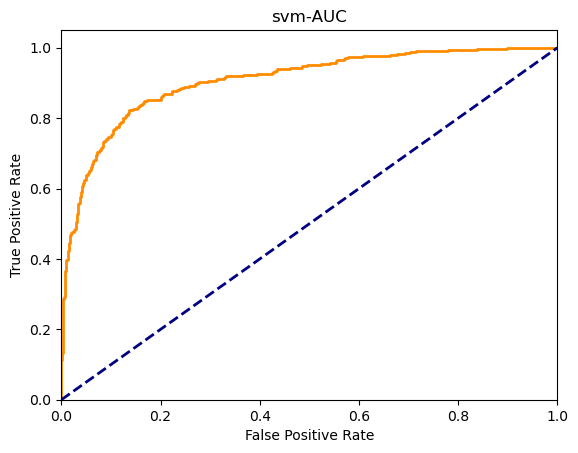

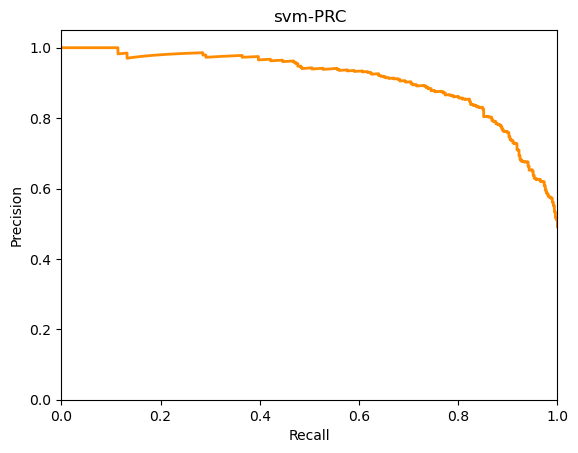

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       509
           1       0.84      0.84      0.84       491

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

AUC: 90.67% PRC: 90.95%


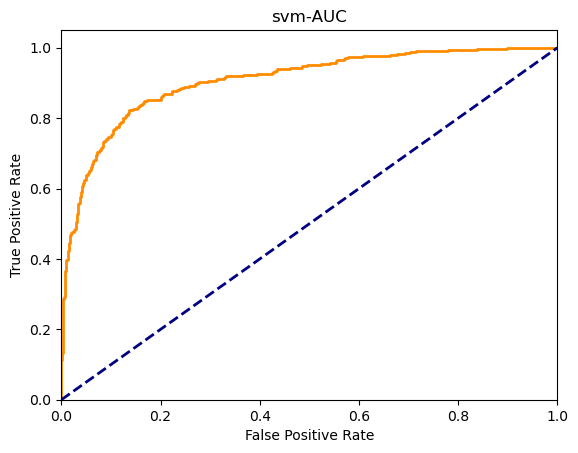

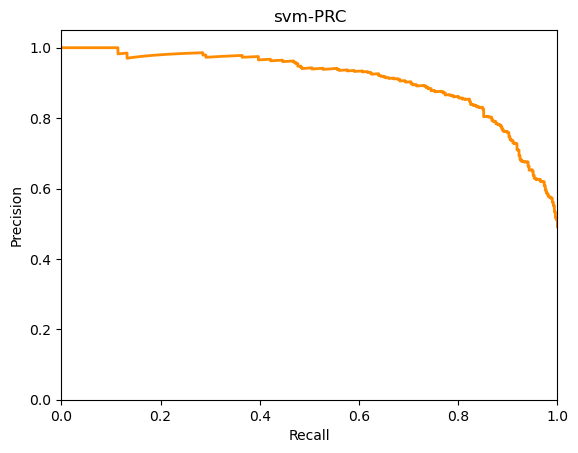

In [33]:
# Test the function with 'svm'
# Compare the default tokenizer and customized tokenizer
# Explain your finding

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=None,model_type='svm',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=MyTokenizer,model_type='svm', min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       509
           1       0.81      0.80      0.80       491

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

AUC: 88.55% PRC: 88.67%


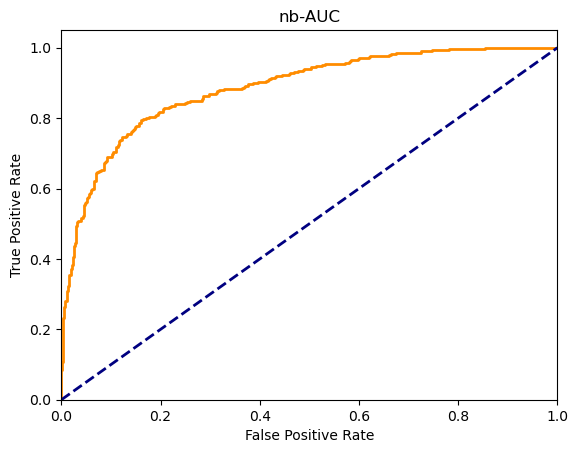

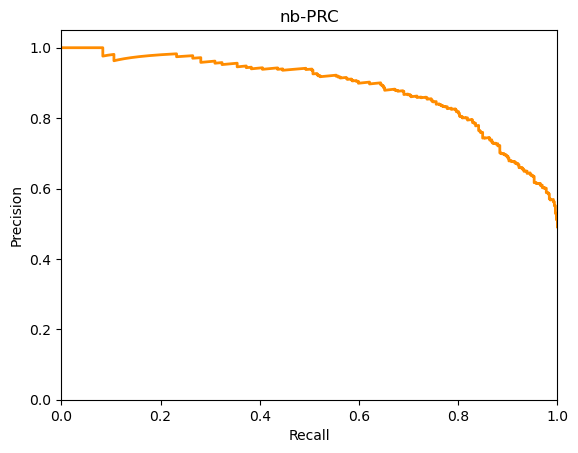

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       509
           1       0.81      0.80      0.80       491

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

AUC: 88.55% PRC: 88.67%


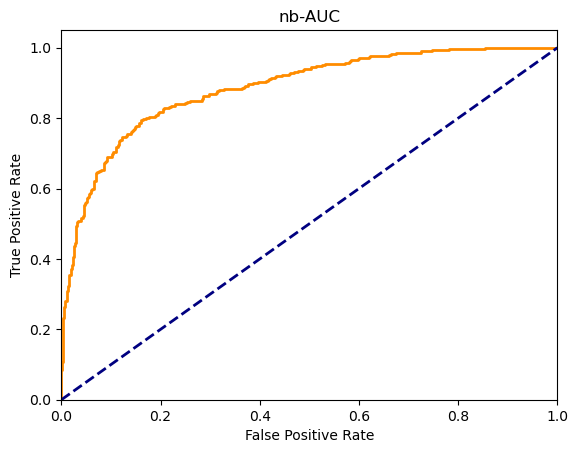

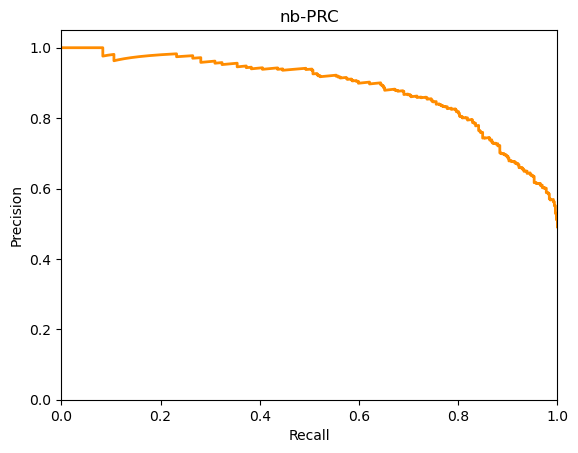

In [34]:
# Test the function with 'nb' 
# Compare the default tokenizer and customized tokenizer
# Explain your finding

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=MyTokenizer,model_type='nb',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)



auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=None,model_type='nb', min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

### Task 2: Search for best parameters 

From Task 1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier 
    - Define the parameter ranges as follow:
        - `stop_words': [None, 'english']`
        - `min_df: [1,2,5]`
        - `C: [0.1,0.5,1]`
    - Set the scoring metric to "f1_macro"
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the best parameter values
    
- Call the function `svm_model` defined in Task 1 (default tokenizer) `with the best parameter values`. You will have to add the best C value to the original function, because you used default settings of the SVM classifier previously. Then please briefly answer the following:
    - Compare with the model in Task 1, how is the performance improved on the test dataset?
    - Why do you think the new parameter values help sentiment classification?

In [35]:
# Define grade search function

def search_para(docs, y):

    # Add your code here
    text_clf = Pipeline(
        [('tfidf', TfidfVectorizer()), ('clf', svm.LinearSVC())])

    parameters = {'tfidf__min_df': [1, 2, 5],
                  'tfidf__stop_words': [None, "english"],
                  'clf__C': [0.1, 0.5, 1],
                  }

    metric = "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters,
                          scoring=metric, cv=5)

    gs_clf = gs_clf.fit(docs, y)

    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name,
                                 gs_clf.best_params_[param_name]))


In [36]:
search_para(train["text"], train["label"])

clf__C:	0.5
tfidf__min_df:	1
tfidf__stop_words:	None


              precision    recall  f1-score   support

           0       0.85      0.84      0.85       509
           1       0.84      0.85      0.84       491

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

AUC: 90.91% PRC: 91.28%


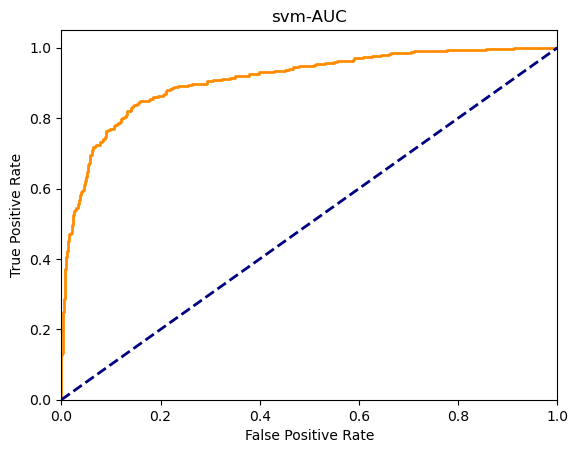

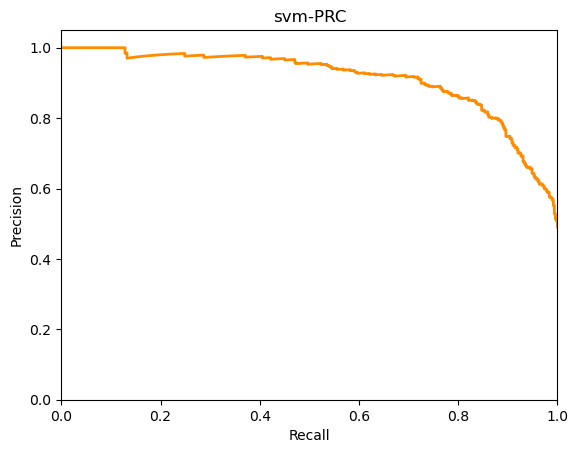

In [37]:
# call the function with the best parameters

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"],
                                    tokenizer=None, model_type='svm',  min_df=1, stop_words=None,
                                    print_result=True, algorithm_para=0.5)
# Please answer the questions
# 1. Task 2 has a higher score in each of the measures, which shows that the best parameters perform better.
# 2. It is more accurate and efficient.


## Task 3. How many samples are enough? 

This task is to help you understand the impact of sample size on classifier performance. 

- Define a function `sample_size_impact(train_docs, train_y, test_docs, test_y)` with the input as defined above. 
    
    
- This function does the following:
    - Starting with 500 samples, in each round you build a classifier with 500 more samples. i.e. in round 1, you use samples from 0:500, and in round 2, you use samples from 0:1000, …, until you use all samples. 
    - In each round, call the `create_model` function with `model_type='svm'` and  `model_type='nb'` and `stop_words='english'`. Keep other parameters as default. Record the AUC score of each model type and the sample size.
    - For each model type, plot a line chart show the relationship between sample size and the AUC score. 
    - This function has no return.
    
    
- Write your analysis on the following:
    - How sample size affects each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
    - How is performance of SVM classifier compared with Naïve Bayes classifier?

In [41]:
# Show the impact of sample size

def sample_size_impact(train_docs, train_y, test_docs, test_y):

    # add your code here
    size = []
    svm_aucs = []
    nb_aucs = []
    count = 0
    
    while count < len(train_y):
        count = min(count+500, len(train_y))

        svm_auc,_ = create_model(train_docs[0:count], train_y[0:count], test_docs, test_y,
                                  model_type='svm', stop_words='english', print_result=False)
        nb_auc,_ = create_model(train_docs[0:count], train_y[0:count], test_docs, test_y,
                                 model_type='nb', stop_words='english', print_result=False)

        size.append(count)
        svm_aucs.append(svm_auc)
        nb_aucs.append(nb_auc)

    plt.figure()
    plt.plot(size, svm_aucs, color='darkorange', lw=2, label='SVM')
    plt.plot(size, nb_aucs, color='navy', lw=2, label='NB')
    plt.legend()
    plt.xlabel('Sample Size')
    plt.ylabel('AUC')
    plt.show()


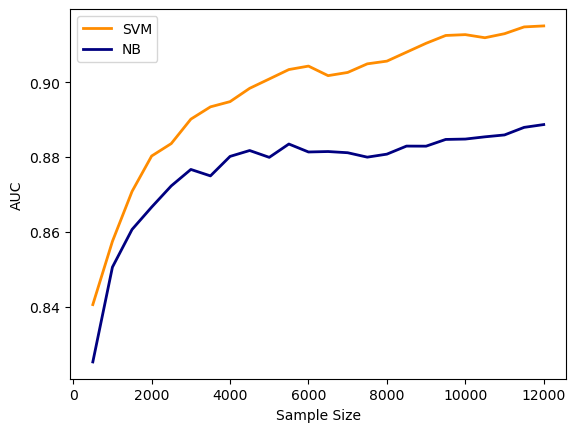

In [42]:
# Test the function

# now we use all the data
train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")

sample_size_impact(train["text"], train["label"], test["text"], test["label"])


# Briefly answer the questions
## 1. The AUC increases along with the sample size.
## 2. With a sample size of 6000, there is little change in the performance of SVM and NB, which is more optimal.
## 3. SVM preforms better than Naïve Bayes.

## Task 4 (Bonus): How to improve sentiment classification?

- Can you tune other parameters of TfidfVectorizer or SVM model to further improve the classification performance? Try to beat the model you get in Task 2!

In [40]:
 # add your code here